# Enoncé du problème

Comment un archer doit-il tirer pour que sa flèche aille le plus loin possible.
<center>
<img src="./dessin_arc.png" width=600>
</center>

# Hypothèses pour une première approche

On néglige:
- la courbure de la terre
- la variation du champs gravitationnel
- l'aérodynamique de la flèche
- la taille de l'archer et de la flèche

On suppose de plus 
- que la vitesse de la flèche en sortie d'arc $v$ est indépendante de l'angle de tir $\theta$.
- que l'origine du repère est au point de départ de la flèche
- qu'on veut atterrir le plus loin à droite

# Equations différentielles

La trajectoire de la flèche est donc décrite par celle d'un point matériel $(x(t), y(t))$ satisfaisant l'équation différentielle
$$
\begin{cases}
\ddot{x}(t) = 0,\\
\ddot{y}(t) = -g
\end{cases}
$$
et les conditions initiales sont
$$
\begin{cases}
x(0)=0\\
y(0)=0\\
\dot{x}(0) = v\cos(\theta)\\
\dot{y}(0)= v\sin(\theta)
\end{cases}
$$

# Imports

In [8]:
# pour des tableaux de nombres pratiques et efficaces
import numpy as np
# pour les figures
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
# pour les calculs symboliques
import sympy as sp
sp.init_printing()
# pour éviter des warnings intempestifs de sympy
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)

# Résolution symbolique

## Création des objets

In [13]:
g, v, theta = sp.symbols("g v \\theta", nonegative=True, real=True)
g, v, theta

In [9]:
t = sp.Symbol("t", nonnegative=True, real=True)
t

In [21]:
x = sp.Function("x", real=True)
x

x

In [22]:
y = sp.Function("y", real=True)
y

y

## Formules générales pour l'EDO

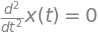

In [49]:
# construction de l'edo sur x
ode_x = sp.Eq(
    sp.Derivative(x(t), t, t), 
    0
)
ode_x

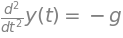

In [53]:
# construction de l'edo sur y
# méthode alternative pour la dérivation
ode_y = sp.Eq(
    y(t).diff(t, 2),
    -g
)
ode_y

In [59]:
defx, defy = sp.dsolve(
    eq=[ode_x, ode_y], 
    func=[x(t), y(t)], 
)
defx, defy

## Calcul des constantes

In [60]:
_, solx = defx.args
_, soly = defy.args
solx, soly

In [62]:
constantes = sp.solve(
    [
        sp.Eq(solx.subs(t, 0), 0),
        sp.Eq(solx.diff(t).subs(t, 0), v*sp.cos(theta)),
        sp.Eq(soly.subs(t,0), 0),
        sp.Eq(soly.diff(t).subs(t, 0), v * sp.sin(theta)),
    ]
)
constantes

In [66]:
formule_x = solx.subs(constantes)
formule_x

In [67]:
formule_y = soly.subs(constantes)
formule_y

## Optimisation

In [70]:
_, t_final = sp.solve(formule_y, t)
t_final

In [73]:
longueur = formule_x.subs(t, t_final)
longueur

In [75]:
res = sp.solve(longueur.diff(theta), theta)
res

In [76]:
longueur.subs(theta, res[1])

# Résolution numérique


## Schéma numérique

On a donc pour $h<<1$ 
$$
\begin{cases}
u_{n+1} = u_n,\\
w_{n+1} = w_n -gh,\\
x_{n+1} = x_n + h u_n,\\
y_{n+1} = y_n + h w_n
\end{cases}
$$
avec aussi
$$
\begin{cases}
x_0=0\\
y_0=0\\
u_0 = v\cos(\theta)\\
w_0= v\sin(\theta)
\end{cases}
$$


## Discrétisation

In [4]:
from dataclasses import dataclass

@dataclass
class Donnees:
    """Paramètres du problème.
    
    g: gravité, 
    v : vitesse de la flèche en sortie d'arc
    theta: angle de la flèche en sortie d'arc
    """
    g: float
    v: float
    theta: float
    
@dataclass 
class Etat:
    """Encode l'état du système à un instant donné."""
    x: float
    y: float
    u: float
    w: float
    

In [5]:
def resolution_numerique(
    nb_pas: int,
    etat_ini: Etat, 
    h: float, 
    donnee: Donnees
) -> list[Etat]:
    """Implémente le schéma d'Euler explicite."""
    resultat = list()
    resultat.append(etat_ini)
    for _ in range(nb_pas):
        ancien = resultat[-1]
        nouveau = Etat(
            x=ancien.x + h*ancien.u,
            y=ancien.y + h * ancien.w,
            u=ancien.u,
            w=ancien.w - donnee.g * h,
        )
        resultat.append(nouveau)
    return resultat
        
    
    

In [6]:
def affichage(etats: list[Etat], h: float):
    """Affichage de la courbe correspondant à une liste d'états."""
    xs=[etat.x for etat in etats]
    ys=[etat.y for etat in etats]
    plt.plot(xs, ys)
    plt.scatter(xs[0], ys[0])

In [7]:
donnee = Donnees(g=9.8, v=60, theta=1.)
ini = Etat(
    x=0,
    y=0,
    u=donnee.v * np.cos(donnee.theta),
    w=donnee.v * np.sin(donnee.theta)
)

etats = resolution_numerique(
    nb_pas=100,
    etat_ini = ini,
    h=0.1,
    donnee=donnee,
)

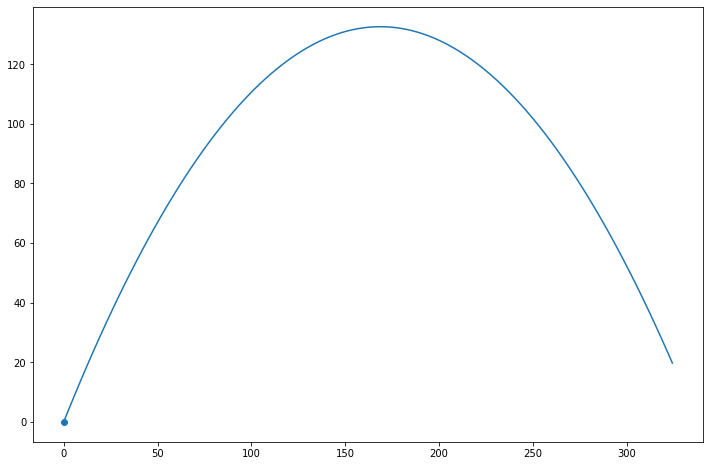

In [8]:
affichage(etats=etats, h=0.1)

## Optimisation

In [9]:
def calcule_arrivee( 
    theta: float,
    h: float=0.01, 
) -> float:
    """Calcule du point d'arrivée.
    
    theta: angle au départ
    h: paramètre de discrétisation
    """
    donnee = Donnees(g=9.8, v=60, theta=theta)
    courant = Etat(
        x=0,
        y=0,
        u=donnee.v * np.cos(donnee.theta),
        w=donnee.v * np.sin(donnee.theta)
    )
    while True:
        courant = Etat(
            x=courant.x + h*courant.u,
            y=courant.y + h * courant.w,
            u=courant.u,
            w=courant.w - donnee.g * h,
        )
        if courant.y < 0:
            return courant.x

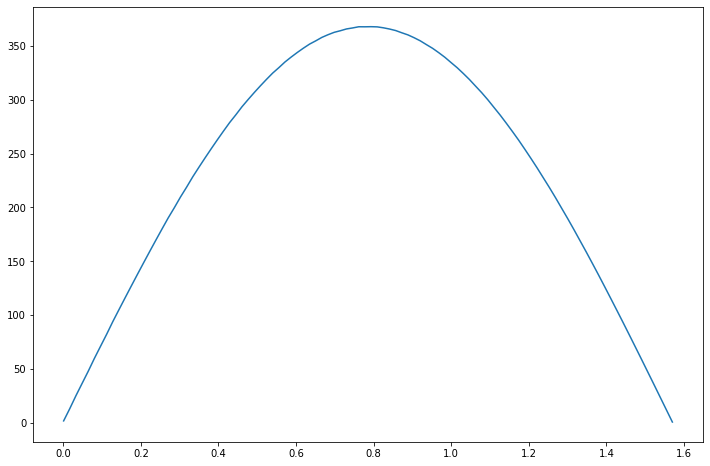

In [10]:
angles = np.linspace(0.001, np.pi / 2 - 0.001, 100)
distances = [calcule_arrivee(theta=angle) for angle in angles]
plt.plot(angles, distances)

In [11]:
def recherche_max(nb_points: int=100, h: float=0.01) -> tuple[float, float]:
    """Recherche exhaustive de la longueur maximale et de l'angle correspondant."""
    angles = np.linspace(0.001, np.pi / 2 - 0.001, nb_points)
    distances = [calcule_arrivee(theta=angle, h=h) for angle in angles]
    distance_max = max(distances)
    angle_max = angles[distances.index(distance_max)]
    return angle_max, distance_max

In [12]:
# Vraie valeur théorique pour comparaison
# Voir la partie symbolique
np.pi / 4

0.7853981633974483

In [13]:
recherche_max(nb_points=100)

(0.7933213771691399, 367.85720621386133)

In [14]:
recherche_max(nb_points=1000)

(0.779901879970239, 368.14675941266137)

In [15]:
recherche_max(nb_points=100, h=0.001)

(0.777474949625757, 367.36168521433626)

In [16]:
recherche_max(nb_points=1000, h=0.001)

(0.7830426133572158, 367.4265978180546)

# Exercice

- Implémenter une méthode de gradient naïve (inspirée de la méthode de Newton) pour déterminer un maximum.
- Prendre en compte l'aspect aérodynamique de la flèche avec un frottement.
- Regarder comment estimer le paramètre de frottement avec l'air à partir de valeur de la fonction de tir.
- Prenez en compte aussi la courbure de la terre.
- Puis le champs de gravitation réel.
- Regarder les bibliothèques `scipy.integrate` pour la résolution d'EDO et `scipy.optimize` pour l'optimisation.